In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.fft import fft, ifft
from scipy.signal import periodogram
import ordpy 
import statsmodels.api as sm
from scipy.signal import butter,filtfilt
from matplotlib.pyplot import figure
from os import listdir
from os.path import isfile, join
from statsmodels.tsa.stattools import adfuller

In [2]:
#list all the data files and its path
files = []
onlyfiles = [f for f in listdir('../Data') if isfile(join('../Data', f))]
for i in range(len(onlyfiles)):
    path = '../Data/' + onlyfiles[i]
    files.append(path)
files

['../Data/100288_painpred_2023-01-27_16h15.27.274.csv',
 '../Data/2023_14h04.32.748.csv',
 '../Data/208088_painpred_2023-01-28_10h00.48.841.csv',
 '../Data/380660_painpred_2023-01-27_18h00.30.749.csv',
 '../Data/586986_painpred_2023-01-27_15h23.28.411.csv',
 '../Data/891121_painpred_2023-01-27_13h22.30.344.csv']

# Preprocessing Functions
For windowing, I realise the reaction time is always the longest in the first trial. So I think we could window more (start from 6 seconds) for the first trial?

In [3]:

def window_value(rating, time): #use values instead of timing to window
    rating_windowed_list = []
    time_windowed_list = []
    failed_index_list = [] #capture error in data logging
    #window the trials by finding the first time that they have changed their rating
    for i in range(len(rating)):
        if len(rating) > 1:
            res_unchanged = next(x for x, val in enumerate(rating[i]) if val != rating[i][0])
            rating_windowed = rating[i][res_unchanged:len(rating[i])]
            time_windowed = time[i][res_unchanged:len(rating[i])]
            #replace trials with error in data logging with nan
            #for trials that has a very long reaction time (about 10 seconds), filter it away
            #for trial
            if time_windowed[0] < 10 and len(time_windowed) > 100 and rating_windowed[0] != rating_windowed[-1]:
                rating_windowed_list.append(rating_windowed)
                time_windowed_list.append(time_windowed)
            else:
                rating_windowed_list.append([np.NaN])
                time_windowed_list.append([np.NaN])
                failed_index_list.append(i)
        else:
            rating_windowed_list.append([np.NaN])
            time_windowed_list.append([np.NaN])

    
        
    return rating_windowed_list, time_windowed_list, failed_index_list

    

def lowpass_butter(rating, time, cutoff, order=5):
    lowpass_list = [] #list for all 30 trials
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            N = len(rating[i])
            T = time[i][-1]-time[i][0]
            fs = N/T
            nyq = fs*0.5
            normal_cutoff = cutoff / nyq
            b, a = butter(order, normal_cutoff, btype='low', analog=False)
            y = filtfilt(b, a, rating[i])
            lowpass_list.append(y)
        else:
            lowpass_list.append([np.NaN])
    return lowpass_list
        
        
    

# Analysis Functions

In [4]:
#mean, mean square, root mean square, variance, standard deviation
def mean(rating):
    mean_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            mean_list.append(np.mean(rating[i]))
        else:
            mean_list.append(np.NaN)
    return mean_list

def mean_square(rating, time): #strength/average power of the signal
    mean_square_list = []
    for i in range(len(rating)):
        if len(time[i]) > 1:
            mean_square_list.append(np.sum(rating[i] ** 2)/(max(time[i]) - min(time[i])))
        else:
            mean_square_list.append(np.NaN)
    return mean_square_list

def rms(mean_square_list):
    return np.sqrt(mean_square_list)

def variance(rating,time):
    variance_list = []
    for i in range(len(rating)):
        if len(time[i]) > 1:
            diff_mean_square_sum = np.sum((rating[i] - np.mean(rating[i]))**2)
            variance = diff_mean_square_sum/(max(time[i]) - min(time[i]))
            variance_list.append(variance)
        else:
            variance_list.append(np.NaN)
    return variance_list

def std(variance_list):
    return np.sqrt(variance_list)
  


#frequency np.fft

def fft_data(rating, time):
    fft_weights_list = []
    fft_freq_list = []
    for i in range(len(rating)):
        if len(time[i]) > 1:
            fft_weights = fft(rating[i])
            N = len(fft_weights)
            n = np.arange(N)
            T = time[i][-1]-time[i][0]
            fft_freq = n/T
            fft_weights_list.append(fft_weights)
            fft_freq_list.append(fft_freq)
        else:
            fft_weights_list.append([np.NaN])
            fft_freq_list.append([np.NaN])
    return fft_weights_list, fft_freq_list


#power-spectrum
def power_spectrum(rating,time):
    psd_freq_list = []
    psd_list = []
    for i in range(len(rating)):
        if len(time[i]) > 1:
            N = len(rating[i])
            T = time[i][-1]
            f, S = periodogram(rating[i], N/T, scaling = 'density')
            psd_freq_list.append(f)
            psd_list.append(S)
        else:
            psd_freq_list.append([np.NaN])
            psd_list.append([np.NaN])
    return psd_freq_list, psd_list


#permutation entropy - complexity
def permutation_entropy(rating):
    entropy_list = []
    stat_complexity_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            entropy, stat_complexity = ordpy.complexity_entropy(rating[i])
            entropy_list.append(entropy)
            stat_complexity_list.append(stat_complexity)
        else:
            entropy_list.append(np.NaN)
            stat_complexity_list.append(np.NaN)
    return entropy_list, stat_complexity_list

#autocorrelation
def autocorrelation(rating):
    acorr_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            acorr = sm.tsa.acf(rating[i], nlags = int(len(rating[i])))
            acorr_list.append(acorr)
        else:
            acorr_list.append([np.NaN])
    return acorr_list
    
#check stationarity
def adfuller_test(rating):
    adfuller_list = []
    stationary_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            result = adfuller(rating[i])
            adfuller_list.append(result)
            if result[1] <= 0.05:
                stationary_list.append(1)
            else:
                stationary_list.append(0)
        else:
            adfuller_list.append(np.nan)
            stationary_list.append(np.nan)
    labels = ['ADF Test Statistic','p-value','#Lags Used','#Observation Used']
    return adfuller_list, labels, stationary_list

# Plotting the prediction and confidence data
## Filter participants
Replace data with NaN if reaction time > 10 seconds. If more than 20% of the data is > 10 seconds, remove participant

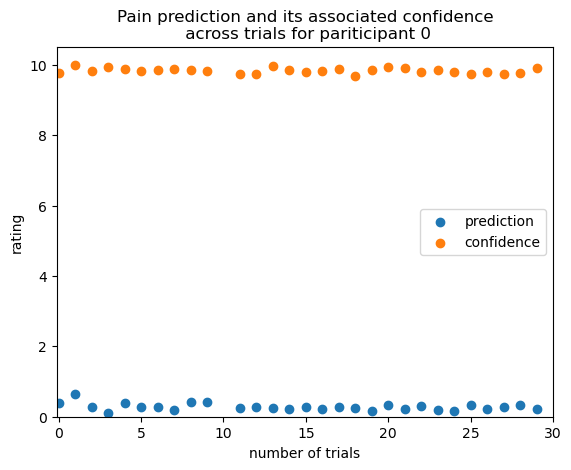

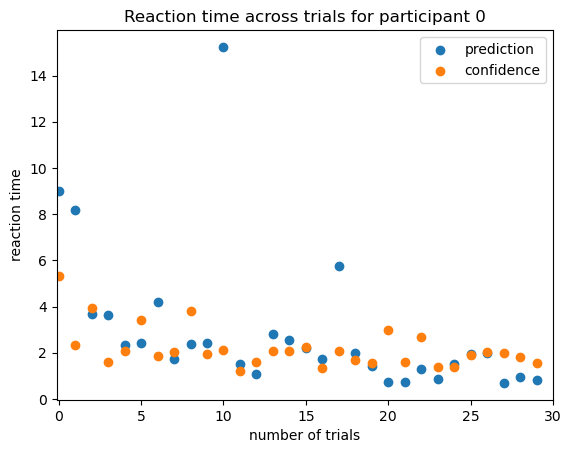

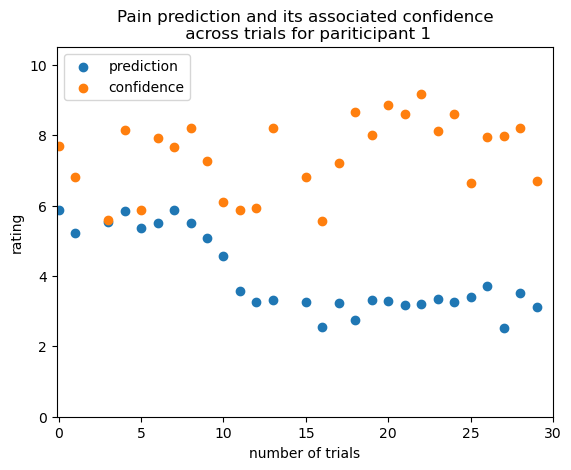

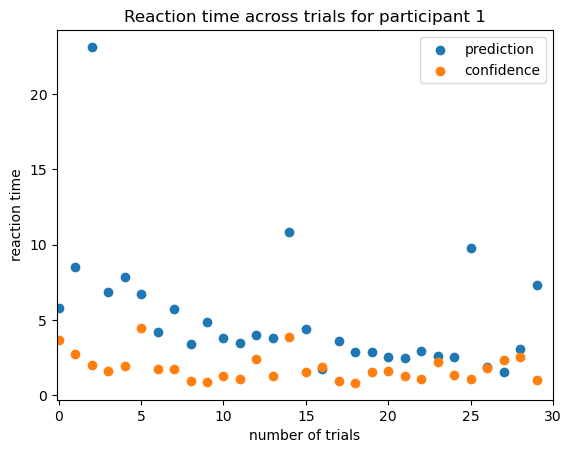

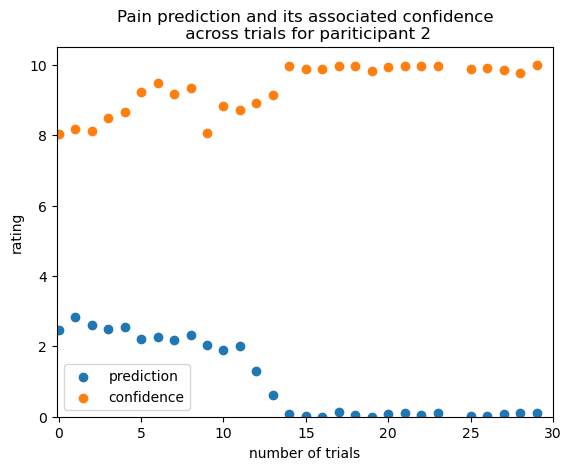

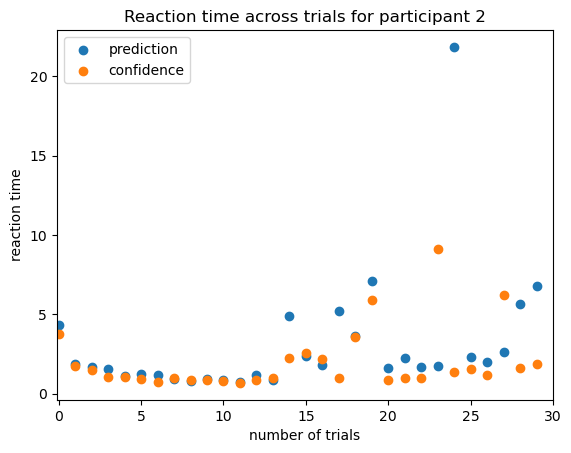

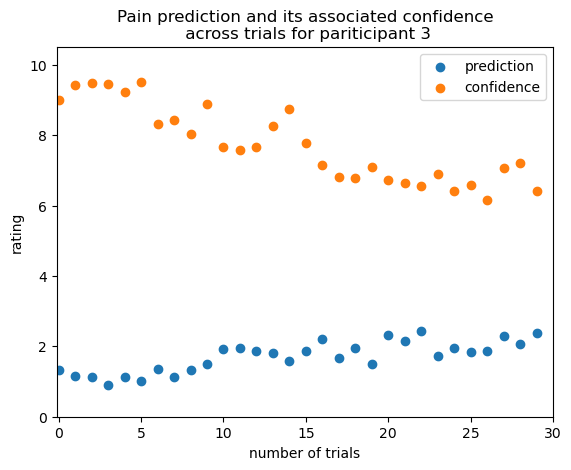

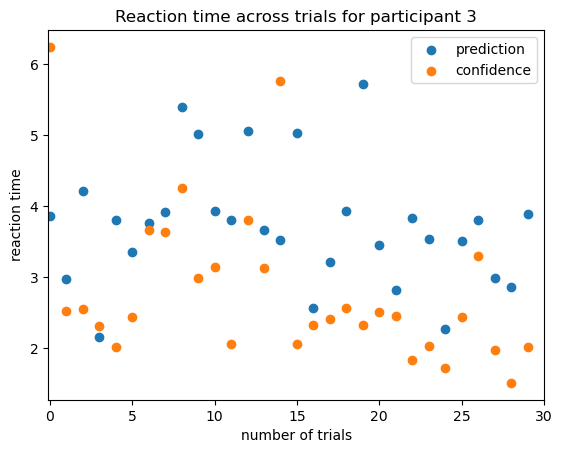

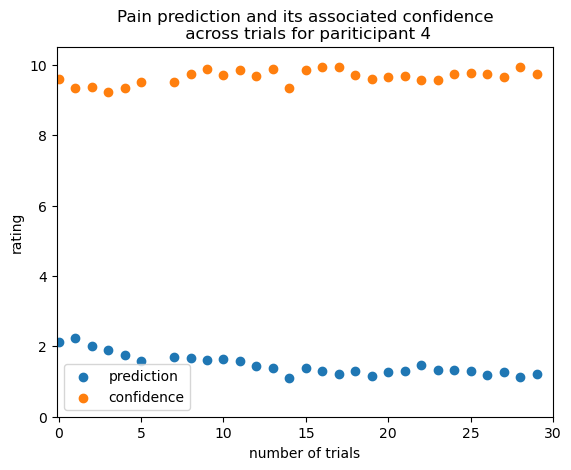

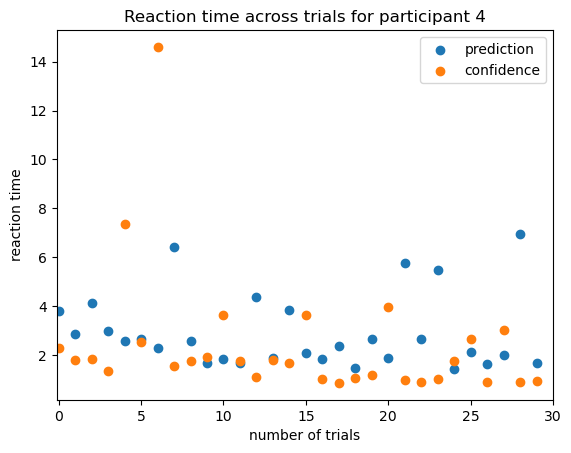

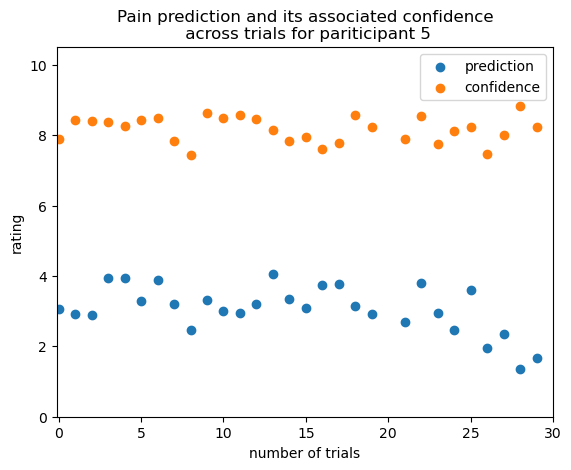

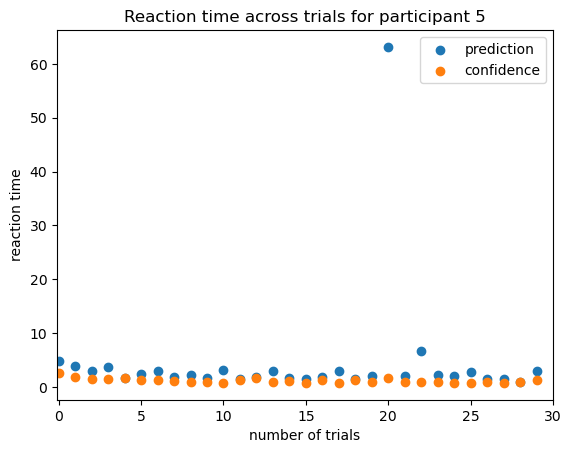

In [5]:
predict_data_all = []
confidence_data_all = []
predict_rt_all = []
confidence_rt_all = []
rej_index_pred = []
rej_index_conf = []
retained_index = []
for file in range(len(files)):
    data = pd.read_csv(files[file])
    predict_data = data['pain_predict_slider.response'][4:len(data)-1].reset_index().drop(columns = 'index')
    confidence_data = data['confidence_slider_2.response'][4:len(data)-1].reset_index().drop(columns = 'index')
    predict_rt = data['pain_predict_slider.rt'][4:len(data)-1].reset_index().drop(columns = 'index')
    confidence_rt = data['confidence_slider_2.rt'][4:len(data)-1].reset_index().drop(columns = 'index')

    #filtering with reaction time
    #replace with nan if reaction time > 10
    predict_rt_bool = pd.Series(predict_rt['pain_predict_slider.rt']) > 10
    index_pred = predict_rt_bool[predict_rt_bool].index
    rej_index_pred.append(index_pred)
    confidence_rt_bool = pd.Series(confidence_rt['confidence_slider_2.rt']) > 10
    index_conf = confidence_rt_bool[confidence_rt_bool].index
    rej_index_conf.append(index_conf)
    confidence_data.iloc[index_pred] = np.NaN
    confidence_data.iloc[index_conf] = np.NaN
    predict_data.iloc[index_pred] = np.NaN
    predict_data.iloc[index_conf] = np.NaN

    #if rejected trials > 10% of overall trials, remove the participant
    threshold = len(predict_data)*0.2
    total_reject = len(index_pred) + len(index_conf)
    if total_reject < threshold:
        retained_index.append(file)
        #append onto array with all data
        predict_data_all.append(predict_data)
        confidence_data_all.append(confidence_data)
        predict_rt_all.append(predict_rt)
        confidence_rt_all.append(confidence_rt)
    else:
        predict_data_all.append(np.nan)
        confidence_data_all.append(np.nan)
        predict_rt_all.append(np.nan)
        confidence_rt_all.append(np.nan)



    #plot
    plt.figure()
    plt.scatter(range(len(predict_data)), predict_data*10, label = 'prediction')
    plt.scatter(range(len(confidence_data)), confidence_data*10, label = 'confidence')
    plt.xlabel('number of trials')
    plt.ylabel('rating')
    plt.ylim(0,10.5)
    plt.xlim(-0.1,len(predict_data))
    plt.title(f'Pain prediction and its associated confidence\n across trials for pariticipant {file}')
    plt.legend()
    plt.figure()
    plt.scatter(range(len(predict_rt)), predict_rt, label = 'prediction')
    plt.scatter(range(len(confidence_rt)), confidence_rt, label = 'confidence')
    plt.xlabel('number of trials')
    plt.ylabel('reaction time')
    plt.xlim(-0.1,len(predict_data))
    plt.title(f'Reaction time across trials for participant {file}')
    plt.legend()

In [6]:
retained_index

[0, 1, 2, 3, 4, 5]

# Put continuous pain data into correct form & visualise

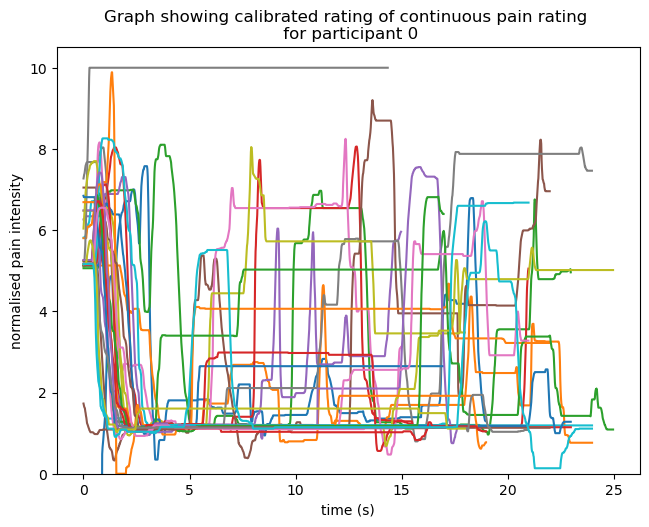

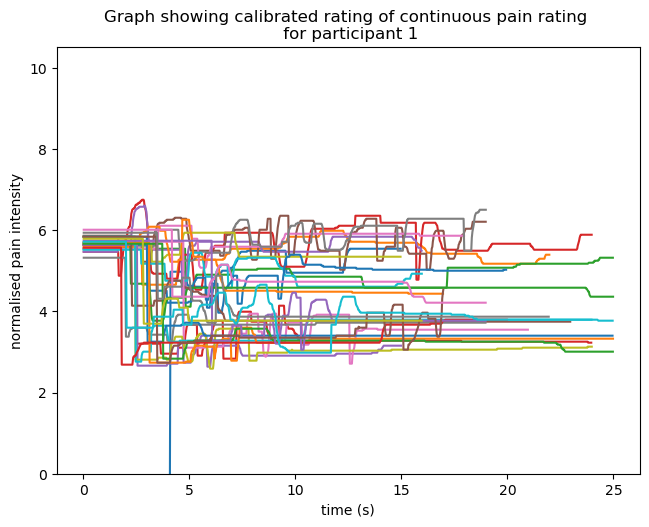

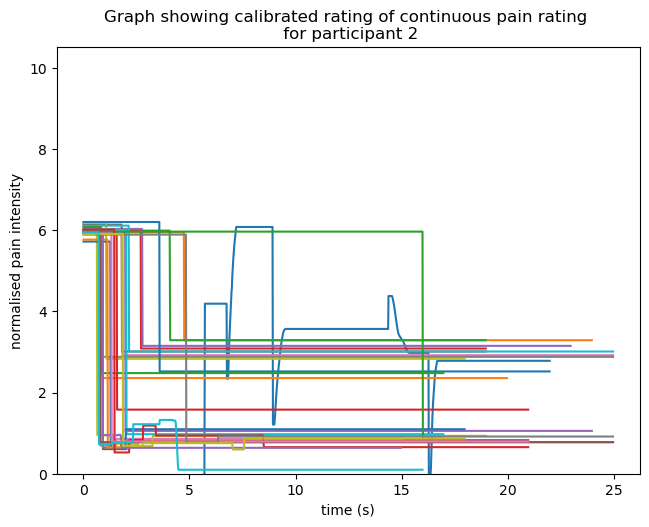

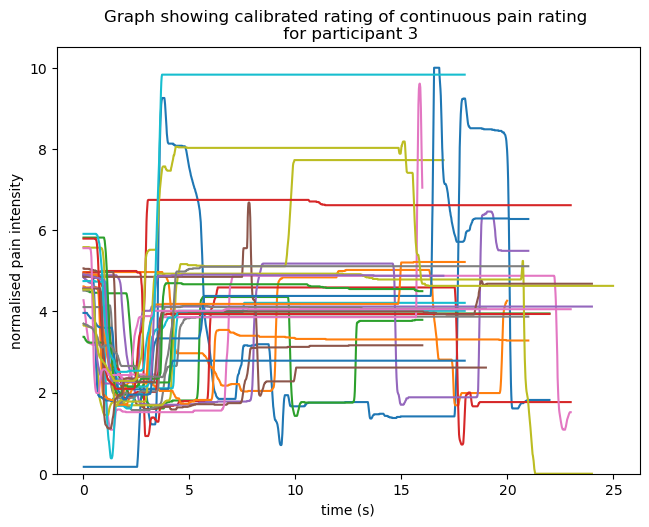

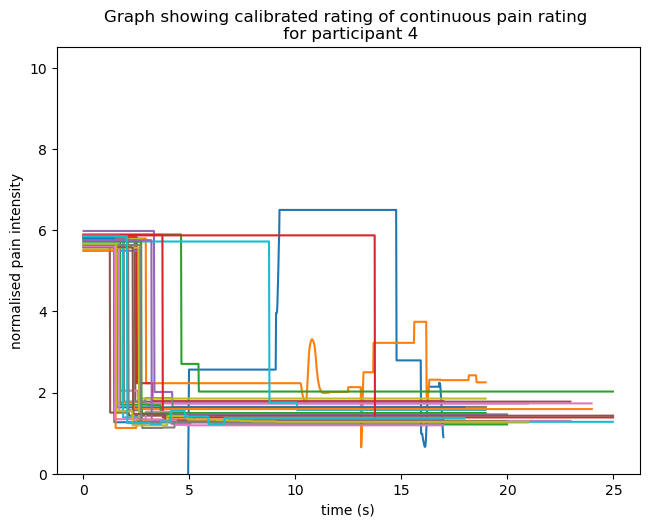

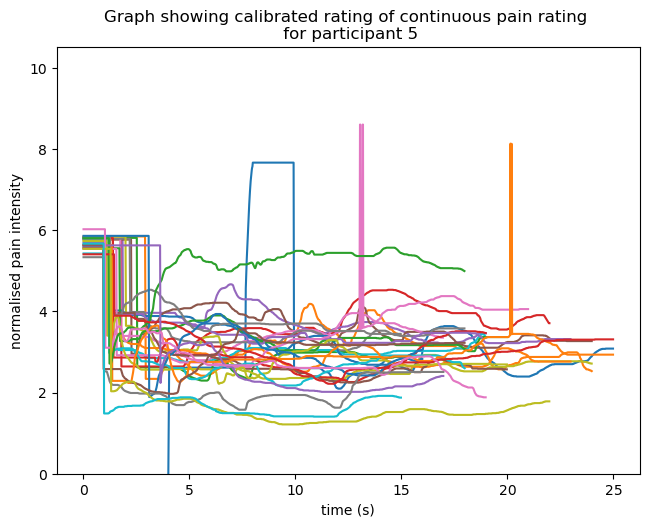

In [7]:
mouse_slider_rating_list_all = []
mouse_slider_time_list_all = []
loops = 30

for index in range(len(files)):
    if index in retained_index:
        plt.figure()
        data = pd.read_csv(files[index])

        #obtain relevant data

        mouse_slider_data = data['mouse_slider.y'][len(data)-1-loops:len(data)-1]
        mouse_slider_data = []
        for j in range(4,len(data),1):
            if type(data['mouse_slider.y'].iloc[j]) == str:
                mouse_slider_data.append([float(data['mouse_slider.y'][j][1:-1].split(",")[i]) for i in range(len(data['mouse_slider.y'][j][1:-1].split(",")))])
        mouse_slider_time = data['mouse_slider.time']
        mouse_slider_time_data = []
        for j in range(4,len(data),1):
            if type(data['mouse_slider.y'].iloc[j]) == str:
                mouse_slider_time_data.append([float(data['mouse_slider.time'][j][1:-1].split(",")[i]) for i in range(len(data['mouse_slider.time'][j][1:-1].split(",")))])
        #calibration (normalise)
        mouse_slider_rating_list = []
        mouse_slider_time_list = []
        mouse_top_position = data['mouse_slider.top'][len(data)-2]
        mouse_bottom_position = data['mouse_slider.bottom'][len(data)-2]
        max_number = []
        min_number = []
        #note the beginning of the first train always starts from below the bottom of the slider due to the artefact from the position of the start button so when normalising we ignore the data of the artefact hence the data is a bit out of range
        for i in range(1,len(mouse_slider_data),1):
            res_0_filtered = next(x for x, val in enumerate(mouse_slider_data[0]) if val != mouse_slider_data[0][0])
            rating_0 = mouse_slider_data[0][res_0_filtered:len(mouse_slider_data[0])]
            max_number.append(max(rating_0))
            min_number.append(min(rating_0))
            max_number.append(max(mouse_slider_data[i]))
            min_number.append(min(mouse_slider_data[i]))
        if max(max_number) > mouse_top_position:
            mouse_top_position = max(max_number)
        if min(min_number) < mouse_bottom_position:
            mouse_bottom_position = min(min_number)
        continuous_length = mouse_top_position - mouse_bottom_position

        for i in range(len(mouse_slider_data)):
            mouse_slider_data_np = np.array(mouse_slider_data[i])
            mouse_slider_time_np = np.array(mouse_slider_time_data[i])
            mouse_slider_time_list.append(mouse_slider_time_np)
            mouse_slider_rating = (mouse_slider_data_np - mouse_bottom_position)/continuous_length*10
            mouse_slider_rating_list.append(mouse_slider_rating)
        mouse_slider_rating_list_all.append(mouse_slider_rating_list)
        mouse_slider_time_list_all.append(mouse_slider_time_list)

        #plot
        for i in range(len(mouse_slider_data)):
            plt.plot(mouse_slider_time_list[i], mouse_slider_rating_list[i], label = i+1)
            plt.ylim(0,10.5)
        #plt.legend()
        plt.tight_layout()
        plt.title(f'Graph showing calibrated rating of continuous pain rating \n for participant {index}')
        plt.xlabel('time (s)')
        plt.ylabel('normalised pain intensity')
    else:
        mouse_slider_rating_list_all.append([np.nan])
        mouse_slider_time_list_all.append([np.nan])
    




# Pre-process the data

In [26]:
#with the timing method
rating_windowed_list_all = []
time_windowed_list_all = []
lowpass_list_all = []
retained_participants_list = []


cutoff = 1
for j in range(len(mouse_slider_rating_list_all)):
    rating_windowed_list, time_windowed_list, failed_index = window_value(mouse_slider_rating_list_all[j], mouse_slider_time_list_all[j])
    rating_windowed_list_all.append(rating_windowed_list)
    time_windowed_list_all.append(time_windowed_list)
    lowpass_list = lowpass_butter(rating_windowed_list, time_windowed_list, cutoff)
    lowpass_list_all.append(lowpass_list)
    if len(failed_index) < 10 and j in retained_index:
        retained_participants_list.append(j)
    

In [9]:
retained_participants_list

[0, 1, 3, 5]

In [10]:
mouse_slider_time_list_all[0][17]

array([1.19999999e-03, 1.65000000e-02, 3.33000000e-02, 5.00000000e-02,
       6.69000000e-02, 8.40000000e-02, 1.01300000e-01, 1.17600000e-01,
       1.34300000e-01, 1.50100000e-01, 1.66600000e-01, 1.83200000e-01,
       1.99900000e-01, 2.16500000e-01, 2.33300000e-01, 2.50200000e-01,
       2.66500000e-01, 2.81500000e-01, 2.97900000e-01, 3.16800000e-01,
       3.34500000e-01, 3.50600000e-01, 3.66600000e-01, 3.82400000e-01,
       3.99500000e-01, 4.17400000e-01, 4.33400000e-01, 4.51400000e-01,
       4.67700000e-01, 4.84400000e-01, 4.99100000e-01, 5.17300000e-01,
       5.34500000e-01, 5.50100000e-01, 5.66900000e-01, 5.83800000e-01,
       6.01200000e-01, 6.16900000e-01, 6.33800000e-01, 6.49400000e-01,
       6.68100000e-01, 6.83000000e-01, 7.00700000e-01, 7.16800000e-01,
       7.32300000e-01, 7.49100000e-01, 7.66700000e-01, 7.83800000e-01,
       8.00200000e-01, 8.16800000e-01, 8.32200000e-01, 8.50300000e-01,
       8.65300000e-01, 8.84100000e-01, 9.00900000e-01, 9.17300000e-01,
      

Note: for the first batch of data, trial number 17 for some reason data jumps from 1.5s to 14s. (see above)

## Plot smoothed data

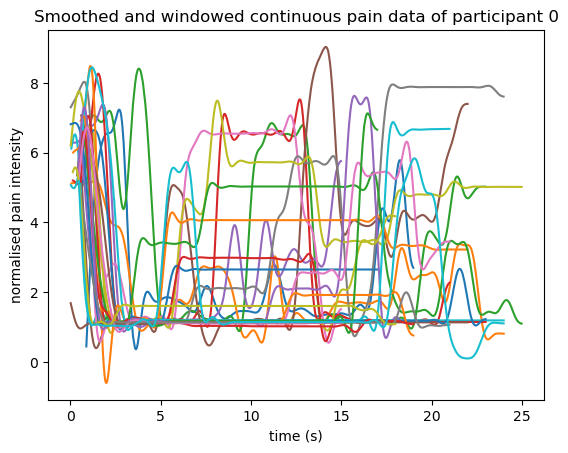

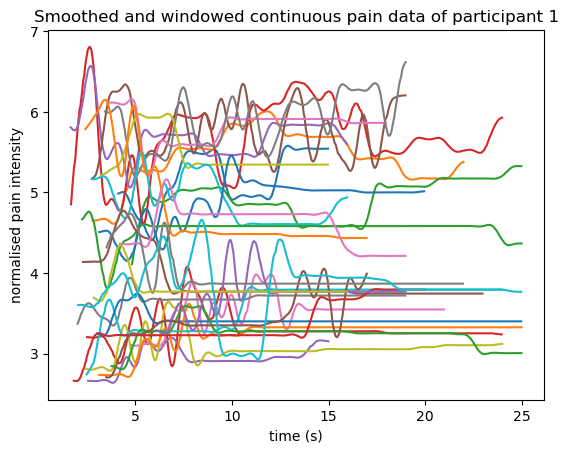

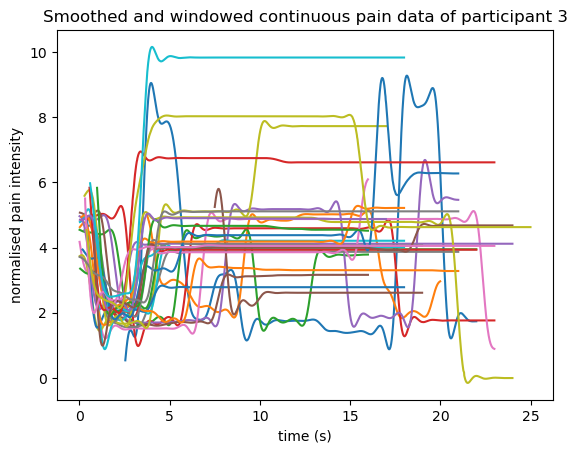

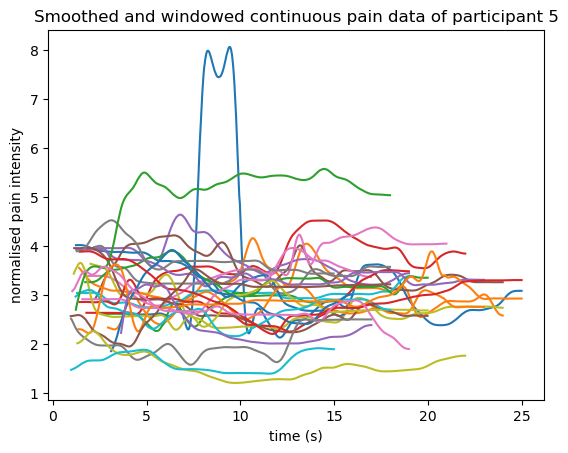

In [27]:
for i in range(len(time_windowed_list_all)):
    if i in retained_participants_list:
        plt.figure()
    
        for j in range(len(time_windowed_list)):
            plt.plot(time_windowed_list_all[i][j],lowpass_list_all[i][j])
            plt.ylabel('normalised pain intensity')
            plt.xlabel('time (s)')
            plt.title(f'Smoothed and windowed continuous pain data of participant {i}')

Problem: 
* participant 3 after smoothing have a pain value of below 0
* if the cutoff frequency of the filter is too high, it creates ripples on the edges of the "step"
* if the cutoff frequency of the filter is too low, it smooths the data too much

# Analysis
## common statistical parameters

In [28]:
mean_list_all = []
mean_square_list_all = []
rms_list_all = []
variance_list_all = []
std_list_all = []
for j in range(len(lowpass_list_all)):
    if j in retained_participants_list:
        mean_list = mean(lowpass_list_all[j])
        mean_square_list = mean_square(lowpass_list_all[j], time_windowed_list_all[j])
        rms_list = rms(mean_square_list)
        variance_list= variance(lowpass_list_all[j], time_windowed_list_all[j])
        std_list = std(variance_list)
        mean_list_all.append(mean_list)
        mean_square_list_all.append(mean_square_list)
        rms_list_all.append(rms_list)
        variance_list_all.append(variance_list)
        std_list_all.append(std_list)
    else:
        mean_list_all.append(np.nan)
        mean_square_list_all.append(np.nan)
        rms_list_all.append(np.nan)
        variance_list_all.append(np.nan)
        std_list_all.append(np.nan)


### Mean

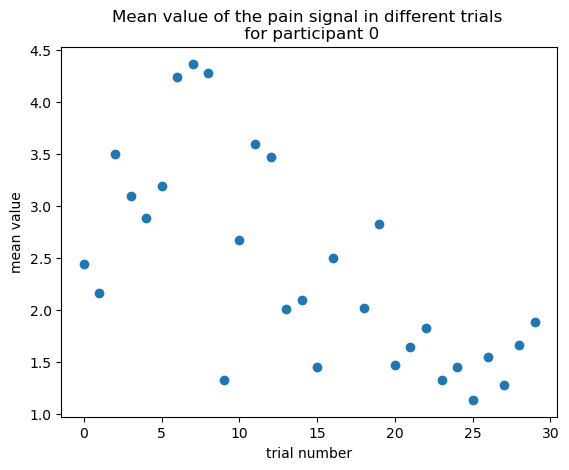

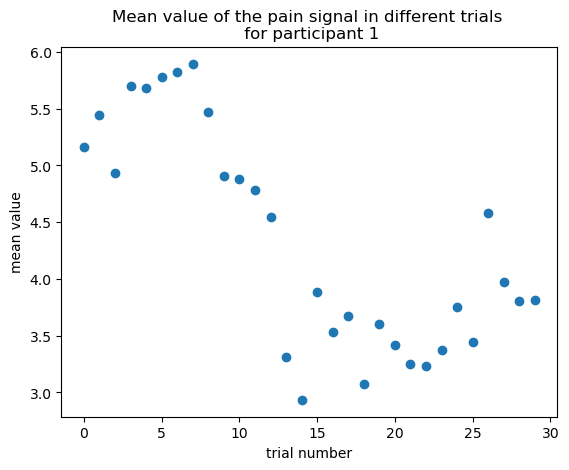

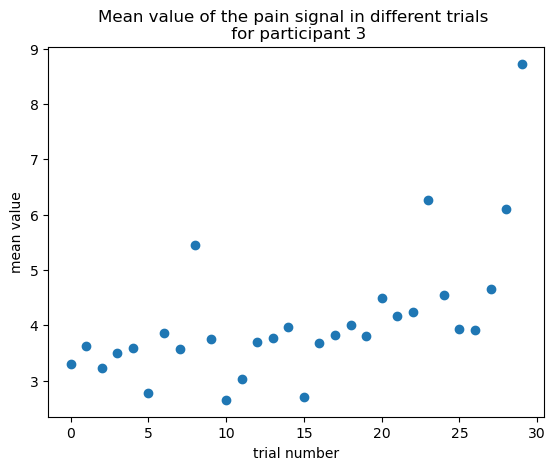

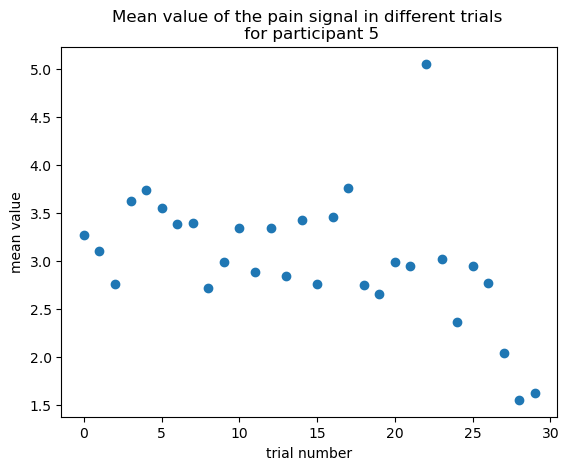

In [29]:
for i in retained_participants_list:
    plt.figure()
    plt.scatter(range(len(mean_list_all[i])), mean_list_all[i])
    plt.xlabel('trial number')
    plt.ylabel('mean value')
    plt.title(f'Mean value of the pain signal in different trials \n for participant {i}')

there's always a large spike somewhere during the task (a few of them have a spike at trial 20 onwards)

### Mean square

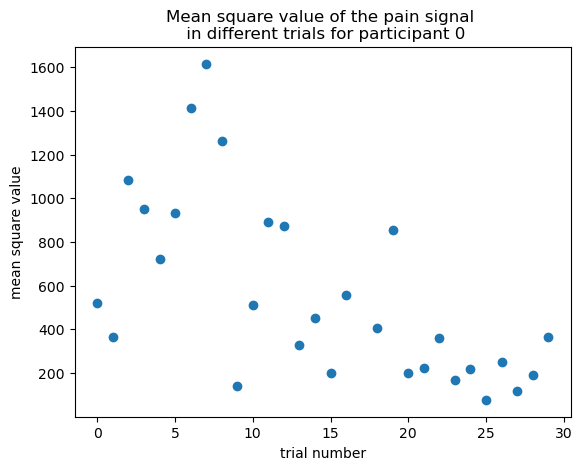

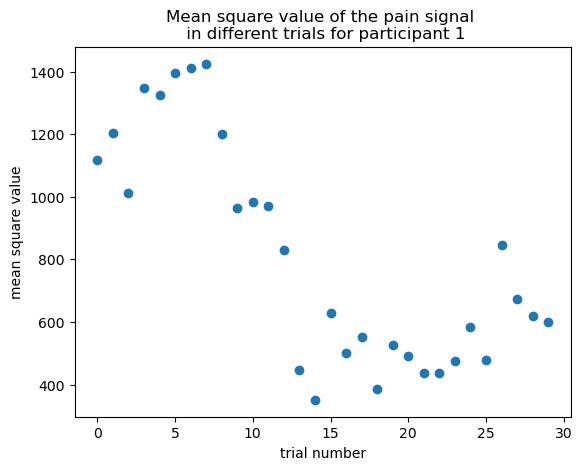

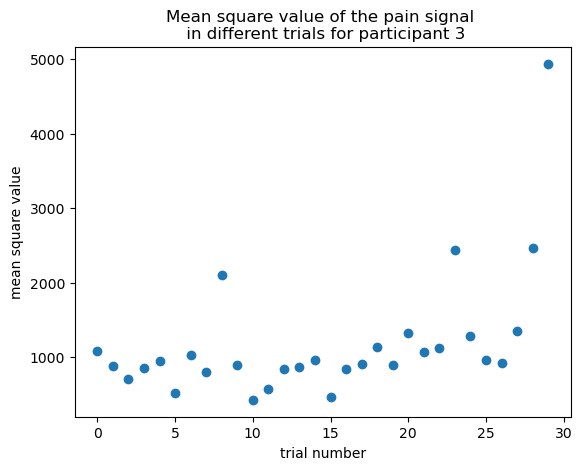

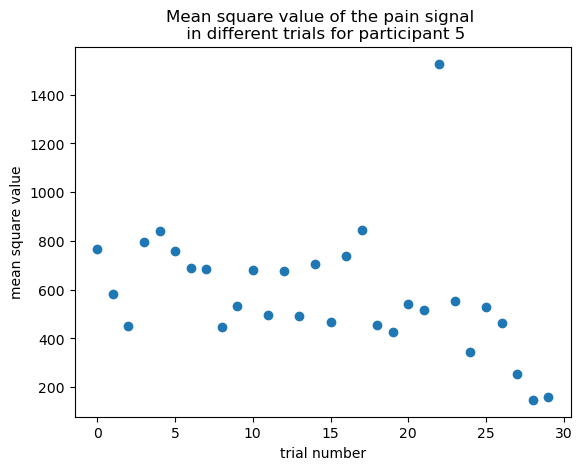

In [30]:
for i in retained_participants_list:
    plt.figure()
    plt.scatter(range(len(mean_square_list_all[i])), mean_square_list_all[i])
    plt.xlabel('trial number')
    plt.ylabel('mean square value')
    plt.title(f'Mean square value of the pain signal \n in different trials for participant {i}')

seem to be spikes of mean square value, some very obvious as well (a few of them have a spike at trial 20 onwards)

### Variance

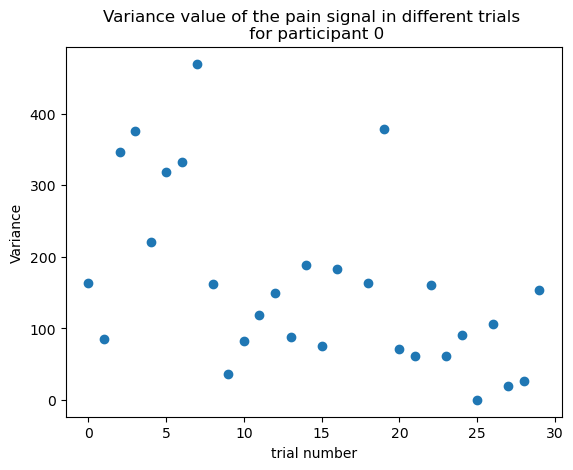

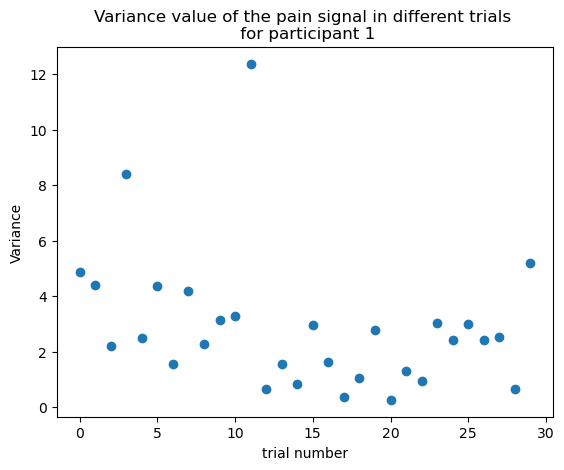

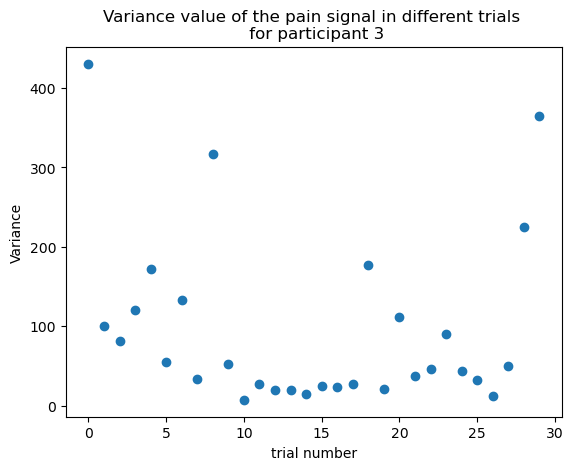

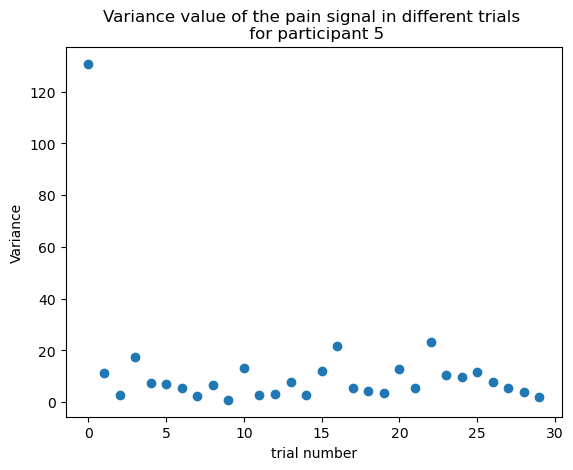

In [31]:
for i in retained_participants_list:
    plt.figure()
    plt.scatter(range(len(variance_list_all[i])), variance_list_all[i])
    plt.xlabel('trial number')
    plt.ylabel('Variance')
    plt.title(f'Variance value of the pain signal in different trials \n for participant {i}')

Interesting seeing spikes of different values of variances throughout the 30 trials, may be interesting looking at the pattern?

## Frequency
### FFT

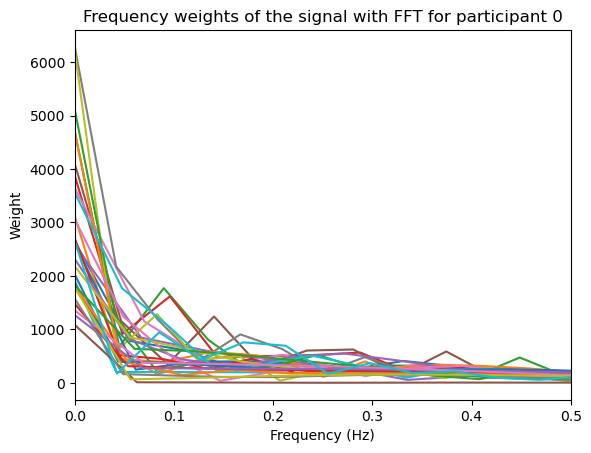

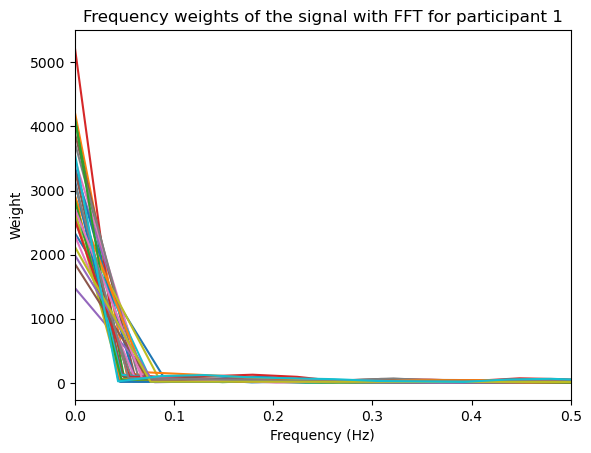

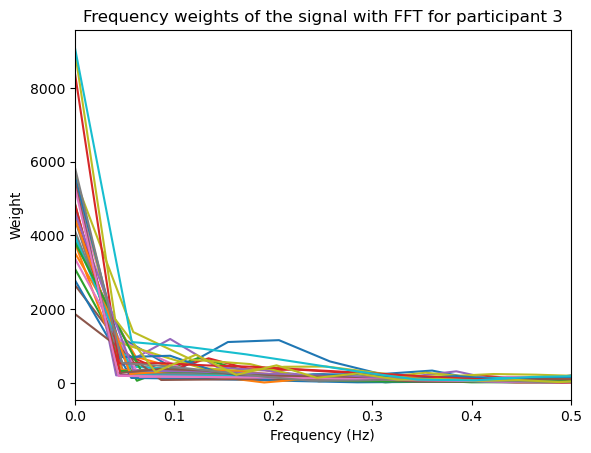

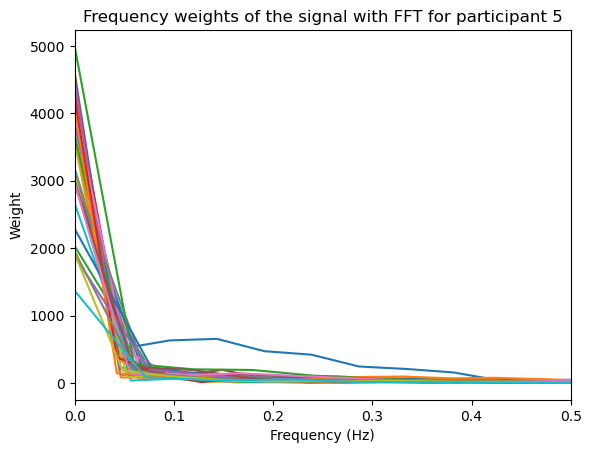

In [32]:
fft_weights_list_all = []
fft_freq_list_all = []
for j in retained_participants_list:
    plt.figure()
    fft_weights_list, fft_freq_list = fft_data(lowpass_list_all[j], time_windowed_list_all[j])
    fft_weights_list_all.append(fft_weights_list)
    fft_freq_list_all.append(fft_freq_list)
    for i in range(len(lowpass_list_all[j])):
        plt.plot(fft_freq_list[i], np.abs(fft_weights_list[i]))
    plt.xlim(0,0.5)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Weight')
    plt.title(f'Frequency weights of the signal with FFT for participant {j}')

### Power spectrum

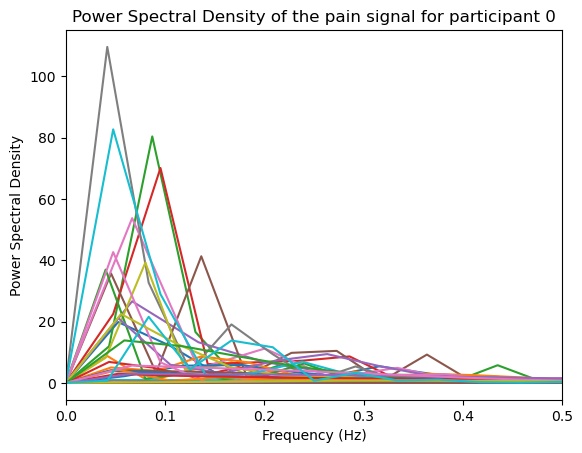

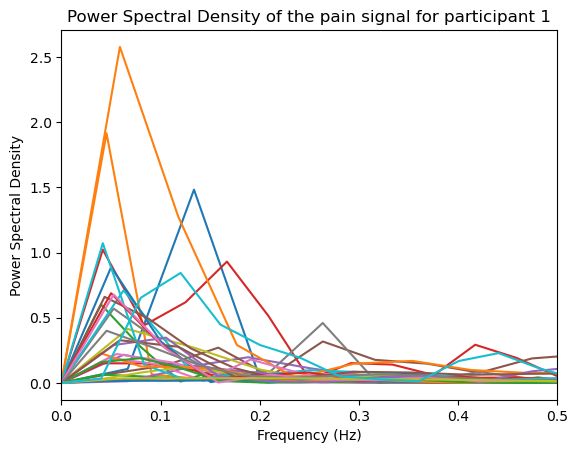

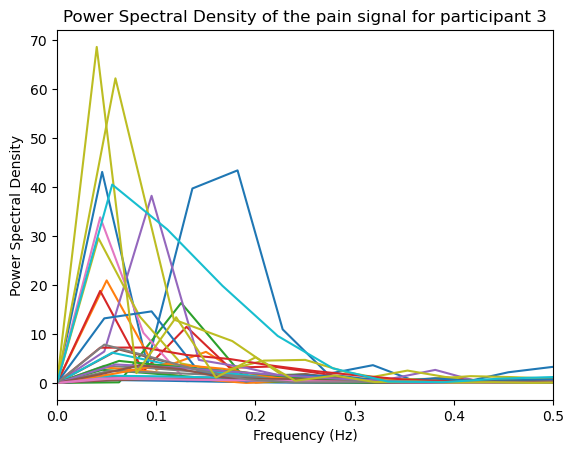

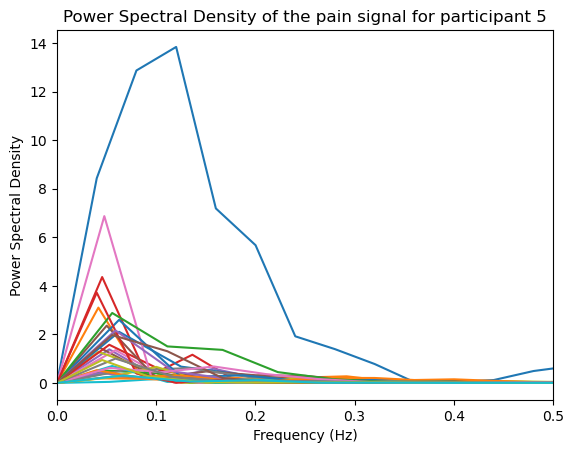

In [33]:
psd_freq_list_all = []
psd_list_all=[]
for j in retained_participants_list:
    plt.figure()
    psd_freq_list, psd_list = power_spectrum(lowpass_list_all[j], time_windowed_list_all[j])
    psd_freq_list_all.append(psd_freq_list)
    psd_list_all.append(psd_list)
    for i in range(len(lowpass_list_all[j])):
        plt.plot(psd_freq_list[i], np.abs(psd_list[i]))
    plt.xlim(0,0.5)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density')
    plt.title(f'Power Spectral Density of the pain signal for participant {j}')

## Permutation entropy

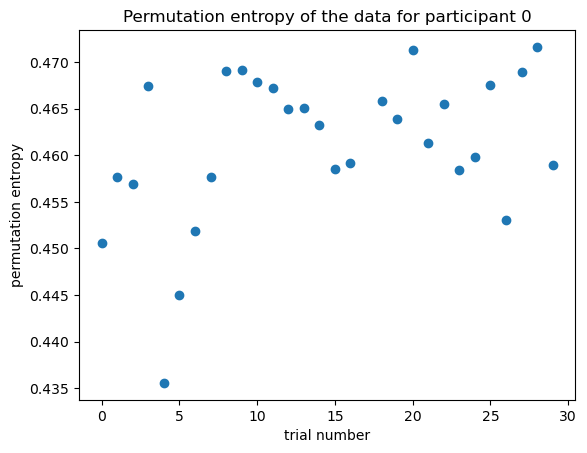

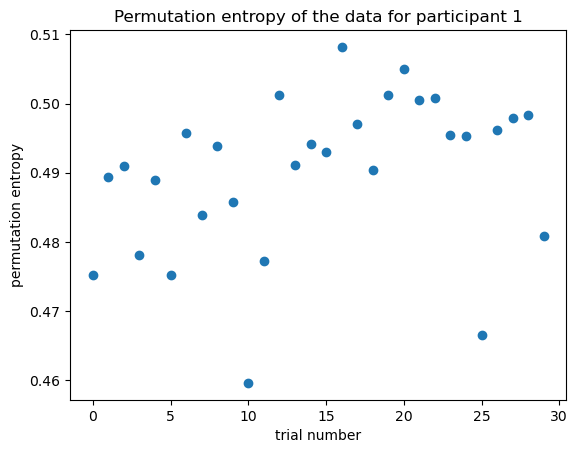

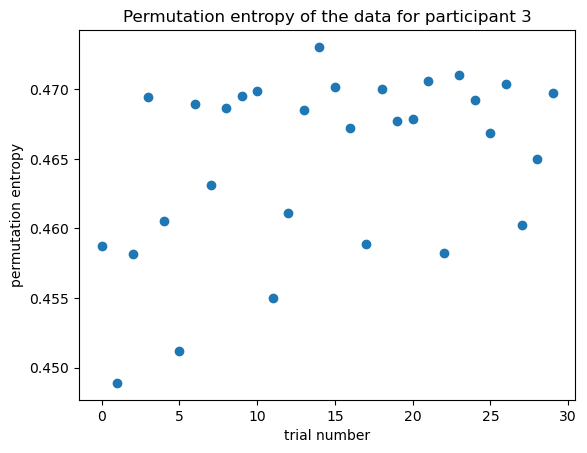

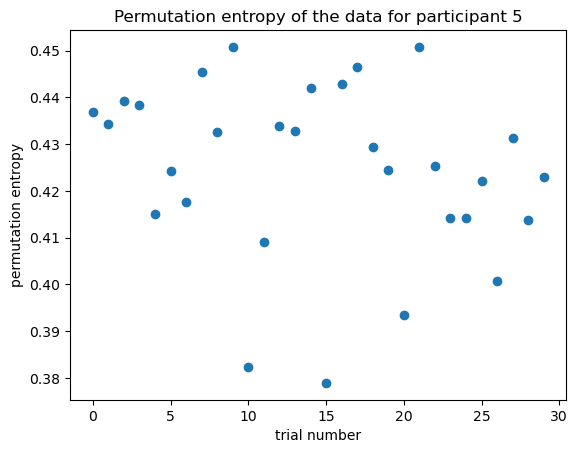

In [34]:
entropy_list_all = []
stat_complexity_list_all = []
for i in retained_participants_list:
    plt.figure()
    entropy_list, stat_complexity_list = permutation_entropy(lowpass_list_all[i])
    entropy_list_all.append(entropy_list)
    stat_complexity_list_all.append(stat_complexity_list)
    plt.scatter(range(len(entropy_list)), entropy_list)
    plt.title(f'Permutation entropy of the data for participant {i}')
    plt.xlabel('trial number')
    plt.ylabel('permutation entropy')

It will be interesting to try to look at the fluctuations of entropy as there seem to be a pattern of going up and down?

## Autocorrelation

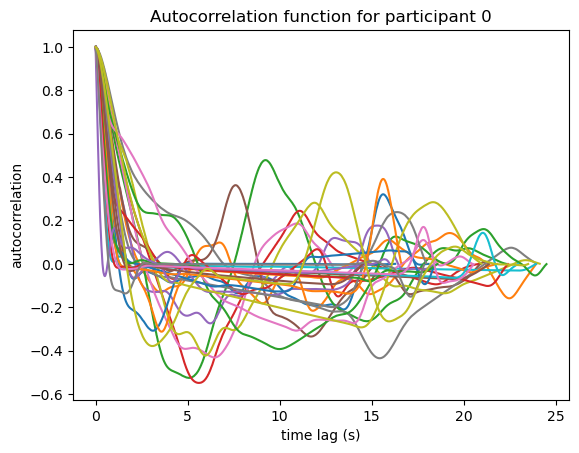

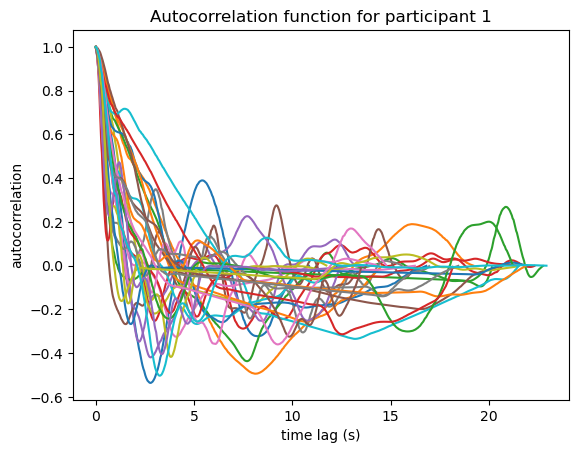

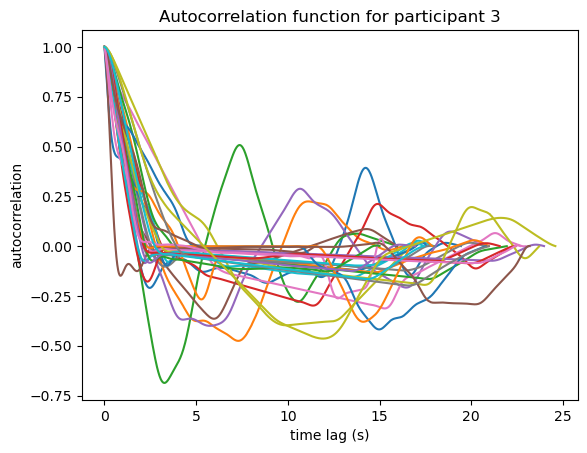

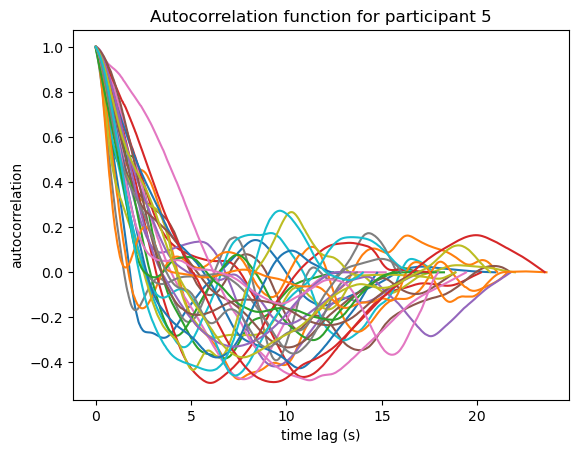

In [35]:
acorr_list_all = []
for j in retained_participants_list:
    plt.figure()
    acorr_list = autocorrelation(lowpass_list_all[j])
    acorr_list_all.append(acorr_list)

    for i in range(len(lowpass_list)):
        if len(time_windowed_list_all[j][i]) > 1:
            time_lag = np.array(time_windowed_list_all[j][i]) - np.array(time_windowed_list_all[j][i][0])
            plt.plot(time_lag, acorr_list[i])
    plt.xlabel('time lag (s)')
    plt.ylabel('autocorrelation')
    plt.title(f'Autocorrelation function for participant {j}')

## Check stationarity

In [36]:
adfuller_list_all = []
stationary_list_all = []
for j in retained_participants_list:
    adfuller_list, labels, stationary_list = adfuller_test(lowpass_list_all[j])
    adfuller_list_all.append(adfuller_list)
    stationary_list_all.append(stationary_list)

In [37]:
stationary_list_all[0]

[1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 nan,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1]